## Dataset + Task Selection
- kalshi/polymarket market and trade data obtained using: https://github.com/Jon-Becker/prediction-market-analysis
- Kalshi Trades: 72 million
- Kalshi Markets: 7.6 million
- This is a complex dataset to be used in a binary classification task (0: loser, 1: winner)

In [70]:
# imports
import duckdb
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from dataclasses import dataclass
from typing import Dict, List

import time

In [71]:
# dataset analysis
con = duckdb.connect()
query = f"""
SELECT count(*)
FROM 'data/kalshi/trades/*.parquet'
"""

df = con.execute(query).df()
df.head()


,count_star()
0,72134741


In [72]:
# dataset analysis
con = duckdb.connect()
query = f"""
SELECT count(*)
FROM 'data/kalshi/markets/*.parquet'
"""

df = con.execute(query).df()
df.head()


,count_star()
0,7682445


In [73]:
# dataset analysis with all features
con = duckdb.connect()
query = f"""
SELECT *
FROM 'data/kalshi/trades/*.parquet' t
    JOIN 'data/kalshi/markets/*.parquet' m USING (ticker)
LIMIT 10
"""

df = con.execute(query).df()
df.head()


,trade_id,ticker,count,yes_price,no_price,taker_side,created_time,_fetched_at,event_ticker,market_type,...,no_ask,last_price,volume,volume_24h,open_interest,result,created_time_1,open_time,close_time,_fetched_at_1
0,5df4ade0-f927-461a-8bc0-d7e23b2cc038,-23MAR-T2,10,1,99,yes,2023-03-27 16:27:26.539290-07:00,2025-11-25 01:20:41.474248,SNOWNYM-23MAR,binary,...,100,1,400,0,157,no,2023-03-10 06:51:51.708324-08:00,2023-03-10 07:00:00-08:00,2023-04-03 07:00:00-07:00,2025-11-24 02:38:17.446565
1,1168cd56-9895-470d-83ab-d6673f821f75,-23MAR-T2,10,1,99,yes,2023-03-27 16:27:18.168809-07:00,2025-11-25 01:20:41.474248,SNOWNYM-23MAR,binary,...,100,1,400,0,157,no,2023-03-10 06:51:51.708324-08:00,2023-03-10 07:00:00-08:00,2023-04-03 07:00:00-07:00,2025-11-24 02:38:17.446565
2,121d116c-ce75-4e9e-8e08-965f6094e62e,-23MAR-T2,10,1,99,yes,2023-03-27 16:27:09.413934-07:00,2025-11-25 01:20:41.474248,SNOWNYM-23MAR,binary,...,100,1,400,0,157,no,2023-03-10 06:51:51.708324-08:00,2023-03-10 07:00:00-08:00,2023-04-03 07:00:00-07:00,2025-11-24 02:38:17.446565
3,f3c052d1-bd82-4284-9b23-77d97d8125f0,-23MAR-T2,10,1,99,yes,2023-03-27 16:27:01.219108-07:00,2025-11-25 01:20:41.474248,SNOWNYM-23MAR,binary,...,100,1,400,0,157,no,2023-03-10 06:51:51.708324-08:00,2023-03-10 07:00:00-08:00,2023-04-03 07:00:00-07:00,2025-11-24 02:38:17.446565
4,f6b42645-bb32-40a1-b5e9-ae1ba414323f,-23MAR-T2,10,1,99,yes,2023-03-27 16:27:01.209590-07:00,2025-11-25 01:20:41.474248,SNOWNYM-23MAR,binary,...,100,1,400,0,157,no,2023-03-10 06:51:51.708324-08:00,2023-03-10 07:00:00-08:00,2023-04-03 07:00:00-07:00,2025-11-24 02:38:17.446565


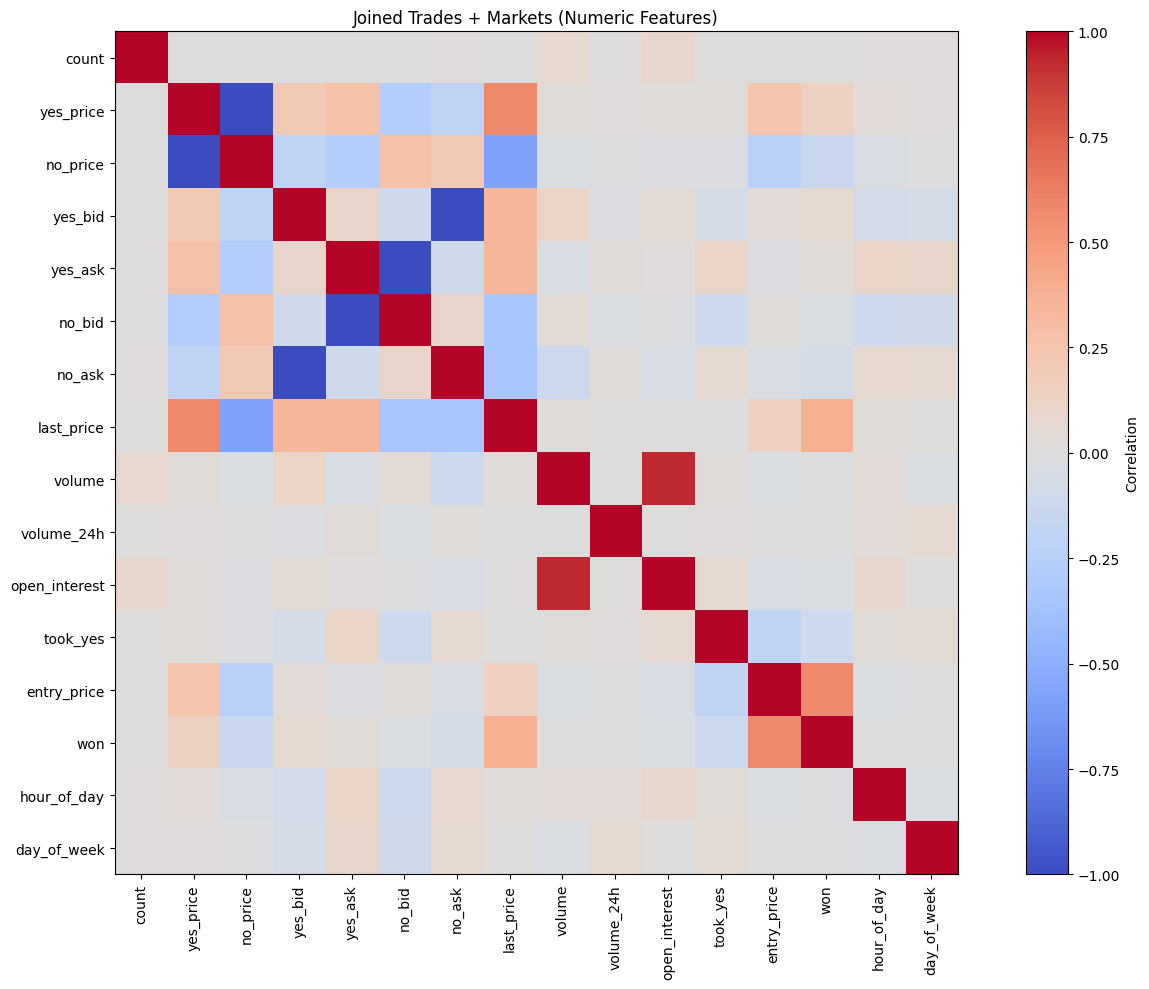

In [74]:
# feature engineering: correlation analysis on joined trades + markets
FEATURE_SAMPLE_ROWS = 100000

con = duckdb.connect()
joined_query = f"""
SELECT *
FROM 'data/kalshi/trades/*.parquet' t
JOIN 'data/kalshi/markets/*.parquet' m USING (ticker)
WHERE m.status = 'finalized'
  AND m.result IN ('yes', 'no')
  AND t.count > 0
  AND t.yes_price BETWEEN 1 AND 99
  AND t.no_price BETWEEN 1 AND 99
USING SAMPLE {FEATURE_SAMPLE_ROWS} ROWS (reservoir)
"""

feature_df = con.execute(joined_query).df()

feature_df['took_yes'] = (feature_df['taker_side'] == 'yes').astype(float)
feature_df['entry_price'] = np.where(
    feature_df['taker_side'] == 'yes',
    feature_df['yes_price'],
    feature_df['no_price'],
).astype(float) / 100.0
feature_df['won'] = (feature_df['taker_side'] == feature_df['result']).astype(float)
feature_df['hour_of_day'] = feature_df['created_time'].dt.hour.astype(float)
feature_df['day_of_week'] = feature_df['created_time'].dt.dayofweek.astype(float)

# scale market/trade prices to probabilities where applicable
for price_col in ['yes_price', 'no_price', 'yes_bid', 'yes_ask', 'no_bid', 'no_ask', 'last_price']:
    if price_col in feature_df.columns:
        feature_df[price_col] = feature_df[price_col].astype(float) / 100.0

numeric_feature_df = feature_df.select_dtypes(include=[np.number]).copy()
corr_matrix = numeric_feature_df.corr(numeric_only=True)

plt.figure(figsize=(14, 10))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title('Joined Trades + Markets (Numeric Features)')
cbar = plt.colorbar()
cbar.set_label('Correlation')
plt.tight_layout()
plt.show()


In [26]:
# find features to select
won_corr = corr_matrix['won'].drop('won').sort_values(key=np.abs, ascending=False)
won_corr_df = won_corr.rename('corr_with_won').to_frame()
display(won_corr_df.head(20))

# pick candidate features by target correlation, then de-duplicate highly collinear columns
corr_threshold = 0.02
max_pairwise_corr = 0.95
candidate_features = won_corr_df.index[won_corr_df['corr_with_won'].abs() >= corr_threshold].tolist()

selected_feature_columns = []
for col in candidate_features:
    if not selected_feature_columns:
        selected_feature_columns.append(col)
        continue

    high_corr = any(
        abs(corr_matrix.loc[col, chosen_col]) >= max_pairwise_corr
        for chosen_col in selected_feature_columns
    )
    if not high_corr:
        selected_feature_columns.append(col)

print('Selected features to move forward with:')
print(selected_feature_columns)
print(f'Total selected: {len(selected_feature_columns)}')

,corr_with_won
entry_price,0.572218
last_price,0.376250
yes_price,0.143927
no_price,-0.143880
took_yes,-0.110726
no_ask,-0.072660
yes_bid,0.072660
open_interest,-0.032524
no_bid,-0.026682
yes_ask,0.026682


Selected features to move forward with:
['entry_price', 'last_price', 'yes_price', 'took_yes', 'no_ask', 'open_interest', 'no_bid', 'hour_of_day']
Total selected: 8


,entry_price,last_price,yes_price,took_yes,yes_bid,open_interest,no_bid,won
entry_price,1.000000,0.146960,0.254486,-0.186947,0.039730,-0.041578,0.009715,0.571452
last_price,0.146960,1.000000,0.567386,-0.007384,0.337029,0.005102,-0.336411,0.383327
yes_price,0.254486,0.567386,1.000000,0.021225,0.197772,0.027151,-0.270877,0.143866
took_yes,-0.186947,-0.007384,0.021225,1.000000,-0.070099,0.062920,-0.105109,-0.111032
yes_bid,0.039730,0.337029,0.197772,-0.070099,1.000000,0.053576,-0.108387,0.069868
open_interest,-0.041578,0.005102,0.027151,0.062920,0.053576,1.000000,-0.013808,-0.037173
no_bid,0.009715,-0.336411,-0.270877,-0.105109,-0.108387,-0.013808,1.000000,-0.031772
won,0.571452,0.383327,0.143866,-0.111032,0.069868,-0.037173,-0.031772,1.000000


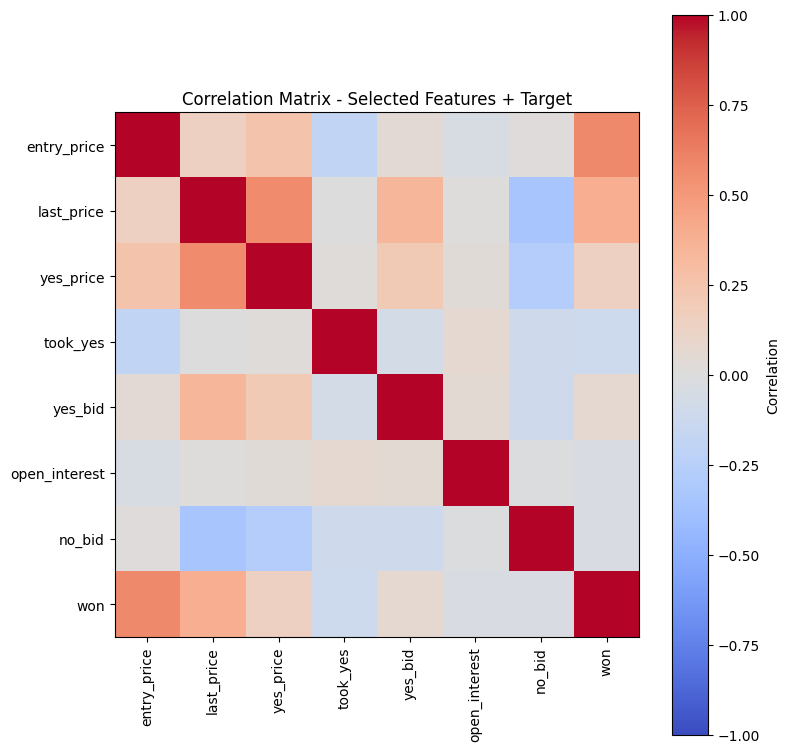

,entry_price,last_price,yes_price,took_yes,yes_bid,open_interest,no_bid,won
0,0.38,0.99,0.62,0.0,0.99,2494105,0.0,0.0
1,0.28,0.01,0.28,1.0,0.00,9156835,0.0,0.0
2,0.59,0.01,0.41,0.0,0.00,32602,0.0,1.0
3,0.19,0.01,0.19,1.0,0.00,39625,0.0,0.0
4,0.29,0.99,0.29,1.0,0.00,61068,0.0,1.0


In [ ]:
# correlation matrix for selected features (+ target)
selected_cols_with_target = selected_feature_columns + ['won'] if selected_feature_columns else ['won']
selected_corr_matrix = feature_df[selected_cols_with_target].corr(numeric_only=True)

display(selected_corr_matrix)

plot_size = max(8, int(len(selected_cols_with_target) * 0.8))
plt.figure(figsize=(plot_size, plot_size))
plt.imshow(selected_corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(range(len(selected_corr_matrix.columns)), selected_corr_matrix.columns, rotation=90)
plt.yticks(range(len(selected_corr_matrix.index)), selected_corr_matrix.index)
plt.title('Correlation Matrix - Selected Features + Target')
cbar = plt.colorbar()
cbar.set_label('Correlation')
plt.tight_layout()
plt.show()

feature_df[selected_cols_with_target].head()


## Part 1: home grown nn

In [64]:

@dataclass
class TrainHistory:
    losses: List[float]


class NeuralNetwork:
    def __init__(
        self,
        layer_sizes: List[int],
        learning_rate: float = 0.01,
        random_seed: int | None = None,
    ) -> None:
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.rng = np.random.default_rng(random_seed)

        self.parameters: Dict[str, np.ndarray] = {}
        self.caches: Dict[str, np.ndarray] = {}
        self._initialize_parameters()

    def _initialize_parameters(self) -> None:
        self.parameters.clear()
        for layer in range(1, len(self.layer_sizes)):
            fan_in = self.layer_sizes[layer - 1]
            fan_out = self.layer_sizes[layer]
            self.parameters[f"W{layer}"] = self.rng.standard_normal(
                (fan_out, fan_in)
            ) * np.sqrt(2.0 / fan_in)
            self.parameters[f"b{layer}"] = np.zeros((fan_out, 1))

    @staticmethod
    def _relu(z: np.ndarray) -> np.ndarray:
        return np.maximum(0.0, z)

    @staticmethod
    def _relu_derivative(z: np.ndarray) -> np.ndarray:
        return (z > 0).astype(float)

    @staticmethod
    def _sigmoid(z: np.ndarray) -> np.ndarray:
        return 1.0 / (1.0 + np.exp(-z))

    def forward_propagation(self, x: np.ndarray) -> np.ndarray:
        a = x
        self.caches = {"A0": x}
        last_layer = len(self.layer_sizes) - 1

        for layer in range(1, last_layer):
            w = self.parameters[f"W{layer}"]
            b = self.parameters[f"b{layer}"]
            z = w @ a + b
            a = self._relu(z)
            self.caches[f"Z{layer}"] = z
            self.caches[f"A{layer}"] = a

        z_last = (
            self.parameters[f"W{last_layer}"] @ a + self.parameters[f"b{last_layer}"]
        )
        a_last = self._sigmoid(z_last)
        self.caches[f"Z{last_layer}"] = z_last
        self.caches[f"A{last_layer}"] = a_last
        return a_last

    def cost(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        epsilon = 1e-12
        y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)
        m = y_true.shape[1]
        loss = (
            -np.sum(y_true * np.log(y_pred) + (1.0 - y_true) * np.log(1.0 - y_pred)) / m
        )
        return float(loss)

    def backward_propagation(
        self, x: np.ndarray, y_true: np.ndarray
    ) -> Dict[str, np.ndarray]:
        m = x.shape[1]
        last_layer = len(self.layer_sizes) - 1
        grads: Dict[str, np.ndarray] = {}

        a_last = self.caches[f"A{last_layer}"]
        d_z = a_last - y_true

        for layer in range(last_layer, 0, -1):
            a_prev = self.caches[f"A{layer - 1}"]
            w = self.parameters[f"W{layer}"]

            grads[f"dW{layer}"] = (d_z @ a_prev.T) / m
            grads[f"db{layer}"] = np.sum(d_z, axis=1, keepdims=True) / m

            if layer > 1:
                z_prev = self.caches[f"Z{layer - 1}"]
                d_a_prev = w.T @ d_z
                d_z = d_a_prev * self._relu_derivative(z_prev)

        return grads

    def _gradient_descent_step(self, grads: Dict[str, np.ndarray]) -> None:
        for layer in range(1, len(self.layer_sizes)):
            self.parameters[f"W{layer}"] -= self.learning_rate * grads[f"dW{layer}"]
            self.parameters[f"b{layer}"] -= self.learning_rate * grads[f"db{layer}"]

    def _iterate_batches(
        self,
        x: np.ndarray,
        y_true: np.ndarray,
        batch_size: int,
        shuffle: bool,
    ):
        sample_count = x.shape[1]
        if shuffle:
            indices = self.rng.permutation(sample_count)
            x_epoch = x[:, indices]
            y_epoch = y_true[:, indices]
        else:
            x_epoch = x
            y_epoch = y_true

        for start in range(0, sample_count, batch_size):
            end = min(start + batch_size, sample_count)
            yield x_epoch[:, start:end], y_epoch[:, start:end]

    def train(
        self,
        x: np.ndarray,
        y_true: np.ndarray,
        epochs: int = 1000,
        print_every: int = 100,
        gradient_descent: str = "batch",
        batch_size: int = 32,
        shuffle: bool = True,
    ) -> TrainHistory:
        mode = gradient_descent.lower()
        sample_count = x.shape[1]
        if mode == "batch":
            effective_batch_size = sample_count
        elif mode == "mini-batch":
            effective_batch_size = min(batch_size, sample_count)
        elif mode == "stochastic":
            effective_batch_size = 1

        losses: List[float] = []

        for epoch in range(1, epochs + 1):
            for x_batch, y_batch in self._iterate_batches(
                x=x,
                y_true=y_true,
                batch_size=effective_batch_size,
                shuffle=shuffle,
            ):
                self.forward_propagation(x_batch)
                grads = self.backward_propagation(x_batch, y_batch)
                self._gradient_descent_step(grads)

            y_pred = self.forward_propagation(x)
            loss = self.cost(y_true, y_pred)
            losses.append(loss)

            if print_every > 0 and (
                epoch == 1 or epoch % print_every == 0 or epoch == epochs
            ):
                print(f"Epoch {epoch}/{epochs} - loss: {loss:.6f}")

        return TrainHistory(losses=losses)

    def predict_proba(self, x: np.ndarray) -> np.ndarray:
        return self.forward_propagation(x)

    def predict(self, x: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        probabilities = self.predict_proba(x)
        return (probabilities >= threshold).astype(int)


In [ ]:
# establish train test split
TRAIN_FRACTION = 0.8

X_full = feature_df[selected_feature_columns].to_numpy(dtype=np.float64)
y_full = feature_df['won'].to_numpy(dtype=np.float64).reshape(-1, 1)

split_rng = np.random.default_rng(42)
indices = split_rng.permutation(X_full.shape[0])
split_idx = int(TRAIN_FRACTION * X_full.shape[0])
train_idx = indices[:split_idx]
test_idx = indices[split_idx:]

X_train_raw = X_full[train_idx]
X_test_raw = X_full[test_idx]
y_train = y_full[train_idx].T
y_test = y_full[test_idx].T

# normalizing
mu = X_train_raw.mean(axis=0, keepdims=True)
sigma = X_train_raw.std(axis=0, keepdims=True)
sigma[sigma == 0] = 1.0

X_train = ((X_train_raw - mu) / sigma).T
X_test = ((X_test_raw - mu) / sigma).T

print('Selected features:', selected_feature_columns)
print('train features shape:', X_train.shape)
print('train labels shape:  ', y_train.shape)
print('test features shape: ', X_test.shape)
print('test labels shape:   ', y_test.shape)


Selected features: ['entry_price', 'last_price', 'yes_price', 'took_yes', 'no_ask', 'open_interest', 'no_bid', 'hour_of_day']
train features shape: (8, 75076)
train labels shape:   (1, 75076)
test features shape:  (8, 18770)
test labels shape:    (1, 18770)


In [66]:
# experiment methods
def accuracy_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(y_true == y_pred))


def run_experiment(
    label: str,
    mode: str,
    epochs: int,
    batch_size: int = 256,
    learning_rate: float | None = None,
):
    learning_rate_by_mode = {
        'batch': 0.1,
        'mini-batch': 0.015,
        'stochastic': 0.003,
    }
    lr = learning_rate if learning_rate is not None else learning_rate_by_mode.get(mode, 0.03)

    model = NeuralNetwork(
        layer_sizes=[X_train.shape[0], 16, 8, 1],
        learning_rate=lr,
        random_seed=7,
    )

    train_kwargs = {
        'epochs': epochs,
        'print_every': max(1, epochs // 5),
        'gradient_descent': mode,
        'shuffle': True,
    }
    if mode == 'mini-batch':
        train_kwargs['batch_size'] = batch_size

    start = time.perf_counter()
    history = model.train(X_train, y_train, **train_kwargs)
    elapsed = time.perf_counter() - start

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    return {
        'label': label,
        'mode': mode,
        'learning_rate': lr,
        'epochs': epochs,
        'batch_size': (batch_size if mode == 'mini-batch' else None),
        'runtime_sec': elapsed,
        'final_loss': history.losses[-1],
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'loss_curve': history.losses,
    }



Running: Batch GD
Epoch 1/500 - loss: 0.725790
Epoch 100/500 - loss: 0.347456
Epoch 200/500 - loss: 0.087129
Epoch 300/500 - loss: 0.041222
Epoch 400/500 - loss: 0.032479
Epoch 500/500 - loss: 0.029604

Running: Mini-batch GD (256)
Epoch 1/20 - loss: 0.610035
Epoch 4/20 - loss: 0.116374
Epoch 8/20 - loss: 0.035223
Epoch 12/20 - loss: 0.029182
Epoch 16/20 - loss: 0.027823
Epoch 20/20 - loss: 0.027278

Running: Stochastic GD
Epoch 1/20 - loss: 0.026340
Epoch 4/20 - loss: 0.025377
Epoch 8/20 - loss: 0.023915
Epoch 12/20 - loss: 0.022904
Epoch 16/20 - loss: 0.021347
Epoch 20/20 - loss: 0.020626


,label,mode,learning_rate,epochs,batch_size,runtime_sec,final_loss,train_accuracy,test_accuracy
1,Mini-batch GD (256),mini-batch,0.015,20,256.0,0.544687,0.027278,0.993020,0.993660
0,Batch GD,batch,0.100,500,NaN,7.314062,0.029604,0.992967,0.993181
2,Stochastic GD,stochastic,0.003,20,NaN,44.993365,0.020626,0.993420,0.993873


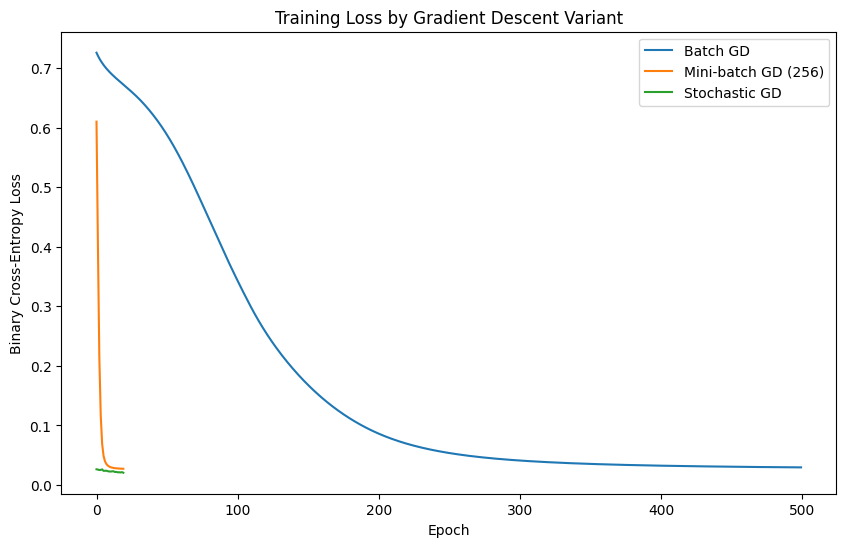

In [53]:
experiments = [
    {'label': 'Batch GD', 'mode': 'batch', 'epochs': 500},
    {'label': 'Mini-batch GD (256)', 'mode': 'mini-batch', 'epochs': 20, 'batch_size': 256},
    {'label': 'Stochastic GD', 'mode': 'stochastic', 'epochs': 20},
]

results = []
for exp in experiments:
    print(f"\nRunning: {exp['label']}")
    result = run_experiment(
        label=exp['label'],
        mode=exp['mode'],
        epochs=exp['epochs'],
        batch_size=exp.get('batch_size', 256),
        learning_rate=exp.get('learning_rate'),
    )
    results.append(result)

results_df = pd.DataFrame([
    {k: v for k, v in item.items() if k != 'loss_curve'}
    for item in results
]).sort_values('runtime_sec')

display(results_df)

plt.figure(figsize=(10, 6))
for item in results:
    plt.plot(item['loss_curve'], label=item['label'])

plt.title('Training Loss by Gradient Descent Variant')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()
plt.show()

batch_runtime = float(results_df.loc[results_df['mode'] == 'batch', 'runtime_sec'].iloc[0])
mini_runtime = float(results_df.loc[results_df['mode'] == 'mini-batch', 'runtime_sec'].iloc[0])

## Reflections
 - reservoir sampling in DuckDB 
 - gives us fixed-size sample with broad coverage. allows for small generalized samples
 - practical to run and compare batch, mini-batch, and stochastic gradient descent with same experiemnt setup (no efficiency problems)

## Part 2: PyTorch 
1. PyTorch model building: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
2. Autograd: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html
3. BCEWithLogitsLoss: https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
4. Optimizers: https://pytorch.org/docs/stable/optim.html
5. DataLoader: https://pytorch.org/docs/stable/data.html
6. Module train/eval modes: https://pytorch.org/docs/stable/generated/torch.nn.Module.html

- helped map the from-scratch NN structure (layers + forward pass) to a clean, modular model definition pattern.
- clarified how gradients are tracked and propagated, so I could correctly connect forward propagation, backward propagation, and parameter updates.



In [75]:
# Part 2 split setup (reuses the same train/test split from Part 1)
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

DEVICE = 'cpu'
X_train_part2_raw = X_train_raw.copy()
X_test_part2_raw = X_test_raw.copy()
y_train_part2 = y_train.T.copy()
y_test_part2 = y_test.T.copy()

DEV_FRACTION_IN_TRAIN = 0.2
part2_rng = np.random.default_rng(RANDOM_SEED)
train_perm = part2_rng.permutation(X_train_part2_raw.shape[0])
dev_count = int(DEV_FRACTION_IN_TRAIN * X_train_part2_raw.shape[0])

dev_idx_part2 = train_perm[:dev_count]
train_idx_part2 = train_perm[dev_count:]

X_train_part2_core_raw = X_train_part2_raw[train_idx_part2]
X_dev_part2_raw = X_train_part2_raw[dev_idx_part2]
y_train_part2_core = y_train_part2[train_idx_part2]
y_dev_part2 = y_train_part2[dev_idx_part2]

# normalize
mu_part2 = X_train_part2_core_raw.mean(axis=0, keepdims=True)
sigma_part2 = X_train_part2_core_raw.std(axis=0, keepdims=True)
sigma_part2[sigma_part2 == 0] = 1.0

X_train_part2_norm = (X_train_part2_core_raw - mu_part2) / sigma_part2
X_dev_part2_norm = (X_dev_part2_raw - mu_part2) / sigma_part2
X_test_part2_norm = (X_test_part2_raw - mu_part2) / sigma_part2

print('Part 2 train-core shape:', X_train_part2_norm.shape, y_train_part2_core.shape)
print('Part 2 dev shape:       ', X_dev_part2_norm.shape, y_dev_part2.shape)
print('Part 2 test shape:      ', X_test_part2_norm.shape, y_test_part2.shape)


Part 2 train-core shape: (60061, 8) (60061, 1)
Part 2 dev shape:        (15015, 8) (15015, 1)
Part 2 test shape:       (18770, 8) (18770, 1)


## Task 2 - NN leveraging packages


In [58]:
class TwoLayerNN(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 32) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)


def build_optimizer(name: str, params, lr: float, weight_decay: float):
    name = name.lower()
    if name == 'sgd':
        return torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=weight_decay)
    if name == 'rmsprop':
        return torch.optim.RMSprop(params, lr=lr, weight_decay=weight_decay)
    if name == 'adam':
        return torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
    raise ValueError("optimizer must be one of: 'sgd', 'rmsprop', 'adam'")


def to_tensor_pair(X: np.ndarray, y: np.ndarray):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    return X_t, y_t


def classification_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    y_true = y_true.astype(int).reshape(-1)
    y_pred = y_pred.astype(int).reshape(-1)

    tp = int(np.sum((y_true == 1) & (y_pred == 1)))
    tn = int(np.sum((y_true == 0) & (y_pred == 0)))
    fp = int(np.sum((y_true == 0) & (y_pred == 1)))
    fn = int(np.sum((y_true == 1) & (y_pred == 0)))

    acc = (tp + tn) / max(1, tp + tn + fp + fn)
    precision = tp / max(1, tp + fp)
    recall = tp / max(1, tp + fn)
    f1 = 2 * precision * recall / max(1e-12, precision + recall)

    return {
        'accuracy': float(acc),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
    }


def evaluate_model(model: nn.Module, X: torch.Tensor, y: torch.Tensor) -> Dict[str, float]:
    loss_fn = nn.BCEWithLogitsLoss()
    model.eval()
    with torch.no_grad():
        logits = model(X.to(DEVICE))
        loss = float(loss_fn(logits, y.to(DEVICE)).item())
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)

    metrics = classification_metrics(y.cpu().numpy(), preds)
    metrics['loss'] = loss
    return metrics


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    X_dev_t: torch.Tensor,
    y_dev_t: torch.Tensor,
    optimizer,
    epochs: int = 60,
    print_every: int = 15,
):
    loss_fn = nn.BCEWithLogitsLoss()
    history = {'train_loss': [], 'dev_loss': []}

    for epoch in range(1, epochs + 1):
        model.train()
        batch_losses = []

        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

            batch_losses.append(float(loss.item()))

        train_loss = float(np.mean(batch_losses))

        model.eval()
        with torch.no_grad():
            dev_logits = model(X_dev_t.to(DEVICE))
            dev_loss = float(loss_fn(dev_logits, y_dev_t.to(DEVICE)).item())

        history['train_loss'].append(train_loss)
        history['dev_loss'].append(dev_loss)

        if print_every > 0 and (epoch == 1 or epoch % print_every == 0 or epoch == epochs):
            print(f'Epoch {epoch}/{epochs} - train loss: {train_loss:.6f} - dev loss: {dev_loss:.6f}')

    return history


def run_torch_experiment(
    label: str,
    optimizer_name: str,
    X_train: np.ndarray,
    y_train_np: np.ndarray,
    X_dev: np.ndarray,
    y_dev_np: np.ndarray,
    X_test: np.ndarray,
    y_test_np: np.ndarray,
    hidden_dim: int = 32,
    learning_rate: float = 0.001,
    weight_decay: float = 1e-4,
    batch_size: int = 256,
    epochs: int = 60,
    print_every: int = 15,
    seed: int = RANDOM_SEED,
):
    torch.manual_seed(seed)

    X_train_t, y_train_t = to_tensor_pair(X_train, y_train_np)
    X_dev_t, y_dev_t = to_tensor_pair(X_dev, y_dev_np)
    X_test_t, y_test_t = to_tensor_pair(X_test, y_test_np)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    model = TwoLayerNN(input_dim=X_train.shape[1], hidden_dim=hidden_dim).to(DEVICE)
    optimizer = build_optimizer(optimizer_name, model.parameters(), learning_rate, weight_decay)

    start = time.perf_counter()
    history = train_model(
        model=model,
        train_loader=train_loader,
        X_dev_t=X_dev_t,
        y_dev_t=y_dev_t,
        optimizer=optimizer,
        epochs=epochs,
        print_every=print_every,
    )
    runtime = time.perf_counter() - start

    train_metrics = evaluate_model(model, X_train_t, y_train_t)
    dev_metrics = evaluate_model(model, X_dev_t, y_dev_t)
    test_metrics = evaluate_model(model, X_test_t, y_test_t)

    summary = {
        'label': label,
        'optimizer': optimizer_name,
        'hidden_dim': hidden_dim,
        'learning_rate': learning_rate,
        'weight_decay': weight_decay,
        'batch_size': batch_size,
        'epochs': epochs,
        'runtime_sec': float(runtime),
        'final_train_loss': train_metrics['loss'],
        'final_dev_loss': dev_metrics['loss'],
        'final_test_loss': test_metrics['loss'],
        'train_accuracy': train_metrics['accuracy'],
        'dev_accuracy': dev_metrics['accuracy'],
        'test_accuracy': test_metrics['accuracy'],
        'test_precision': test_metrics['precision'],
        'test_recall': test_metrics['recall'],
        'test_f1': test_metrics['f1'],
        'history': history,
    }

    return model, summary


## Breakdown
- Activations
  - Hidden layer: ReLU
  - Output layer: no explicit activation raw logits from final linear
- Loss: binary cross-entropy + sigmoid 
- Core model hyperparameters (main runs)
  - Architecture: Linear -> ReLU -> Linear
  - hidden_dim = 32
  - batch_size = 256
  - epochs = 60 (varying based on optimizer)
  - weight_decay = 1e-4 
  - Seeded training (RANDOM_SEED = 42)
- Optimizer settings
  - SGD: lr = 0.03, momentum 0.9
  - RMSprop: lr = 0.001
  - Adam: lr = 0.001

In [76]:
# experiments
optimizer_experiments = [
    {'label': 'SGD', 'optimizer': 'sgd', 'lr': 0.03},
    {'label': 'RMSprop', 'optimizer': 'rmsprop', 'lr': 0.001},
    {'label': 'Adam', 'optimizer': 'adam', 'lr': 0.001},
]

optimizer_results = []
optimizer_histories = {}

for exp in optimizer_experiments:
    print(f"\nRunning {exp['label']}...")
    _, result = run_torch_experiment(
        label=exp['label'],
        optimizer_name=exp['optimizer'],
        X_train=X_train_part2_norm,
        y_train_np=y_train_part2_core,
        X_dev=X_dev_part2_norm,
        y_dev_np=y_dev_part2,
        X_test=X_test_part2_norm,
        y_test_np=y_test_part2,
        hidden_dim=32,
        learning_rate=exp['lr'],
        weight_decay=1e-4,
        batch_size=256,
        epochs=60,
        print_every=15,
        seed=RANDOM_SEED,
    )
    optimizer_results.append({k: v for k, v in result.items() if k != 'history'})
    optimizer_histories[exp['label']] = result['history']

optimizer_results_df = pd.DataFrame(optimizer_results).sort_values('test_accuracy', ascending=False)
display(optimizer_results_df)



Running SGD...
Epoch 1/60 - train loss: 0.156031 - dev loss: 0.029796
Epoch 15/60 - train loss: 0.025283 - dev loss: 0.024064
Epoch 30/60 - train loss: 0.024781 - dev loss: 0.023754
Epoch 45/60 - train loss: 0.024440 - dev loss: 0.023300
Epoch 60/60 - train loss: 0.024233 - dev loss: 0.023184

Running RMSprop...
Epoch 1/60 - train loss: 0.275865 - dev loss: 0.102964
Epoch 15/60 - train loss: 0.024837 - dev loss: 0.023344
Epoch 30/60 - train loss: 0.024282 - dev loss: 0.023028
Epoch 45/60 - train loss: 0.023957 - dev loss: 0.022765
Epoch 60/60 - train loss: 0.023815 - dev loss: 0.022548

Running Adam...
Epoch 1/60 - train loss: 0.448656 - dev loss: 0.210484
Epoch 15/60 - train loss: 0.025073 - dev loss: 0.023653
Epoch 30/60 - train loss: 0.024418 - dev loss: 0.023204
Epoch 45/60 - train loss: 0.024039 - dev loss: 0.022663
Epoch 60/60 - train loss: 0.023788 - dev loss: 0.022553


,label,optimizer,hidden_dim,learning_rate,weight_decay,batch_size,epochs,runtime_sec,final_train_loss,final_dev_loss,final_test_loss,train_accuracy,dev_accuracy,test_accuracy,test_precision,test_recall,test_f1
1,RMSprop,rmsprop,32,0.001,0.0001,256,60,9.881174,0.023586,0.022548,0.022226,0.993157,0.993140,0.993607,0.993547,0.992872,0.993210
2,Adam,adam,32,0.001,0.0001,256,60,9.966018,0.023556,0.022553,0.022149,0.993040,0.993007,0.993607,0.993435,0.992986,0.993210
0,SGD,sgd,32,0.030,0.0001,256,60,9.926873,0.024034,0.023184,0.022705,0.992957,0.992940,0.993394,0.993097,0.992872,0.992985


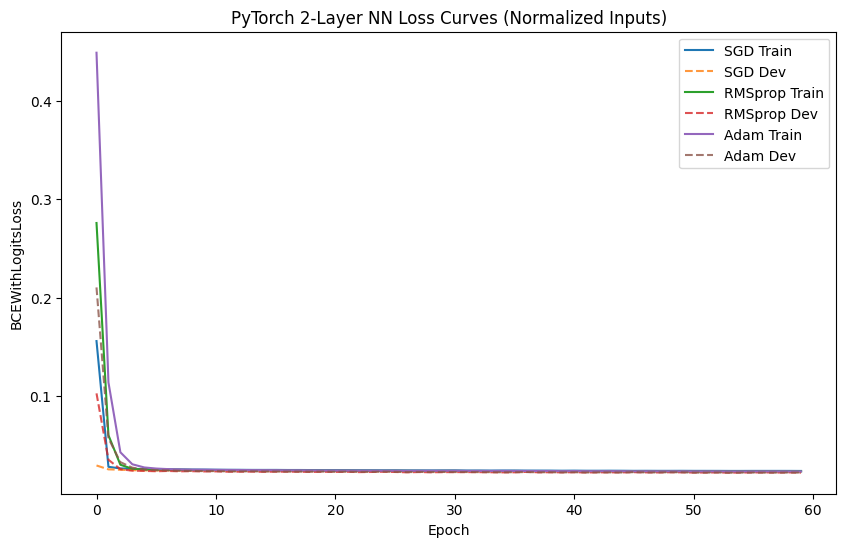

In [60]:
plt.figure(figsize=(10, 6))
for label, hist in optimizer_histories.items():
    plt.plot(hist['train_loss'], label=f'{label} Train')
    plt.plot(hist['dev_loss'], linestyle='--', alpha=0.8, label=f'{label} Dev')

plt.title('PyTorch 2-Layer NN Loss Curves (Normalized Inputs)')
plt.xlabel('Epoch')
plt.ylabel('BCEWithLogitsLoss')
plt.legend()
plt.show()


In [ ]:
# normalization impact experiment (same architecture/optimizer)
norm_results = []

for label, Xtr, Xdv, Xte, lr in [
    ('Unnormalized Inputs', X_train_part2_core_raw, X_dev_part2_raw, X_test_part2_raw, 0.0007),
    ('Normalized Inputs', X_train_part2_norm, X_dev_part2_norm, X_test_part2_norm, 0.001),
]:
    print(f"\nRunning Adam with {label}...")
    _, result = run_torch_experiment(
        label=label,
        optimizer_name='adam',
        X_train=Xtr,
        y_train_np=y_train_part2_core,
        X_dev=Xdv,
        y_dev_np=y_dev_part2,
        X_test=Xte,
        y_test_np=y_test_part2,
        hidden_dim=32,
        learning_rate=lr,
        weight_decay=1e-4,
        batch_size=256,
        epochs=60,
        print_every=15,
        seed=RANDOM_SEED,
    )
    norm_results.append({k: v for k, v in result.items() if k != 'history'})

norm_results_df = pd.DataFrame(norm_results).sort_values('test_accuracy', ascending=False)
display(norm_results_df)

best_norm_row = norm_results_df.iloc[0]
print('\nBest normalization setting by test accuracy:')
print(best_norm_row[['label', 'test_accuracy', 'final_test_loss', 'runtime_sec']])



Running Adam with Unnormalized Inputs...
Epoch 1/60 - train loss: 849.727262 - dev loss: 50.114395
Epoch 15/60 - train loss: 358.998055 - dev loss: 520.923706
Epoch 30/60 - train loss: 272.149011 - dev loss: 11.039789
Epoch 45/60 - train loss: 284.365773 - dev loss: 281.722137
Epoch 60/60 - train loss: 253.737604 - dev loss: 591.502686

Running Adam with Normalized Inputs...
Epoch 1/60 - train loss: 0.448656 - dev loss: 0.210484
Epoch 15/60 - train loss: 0.025073 - dev loss: 0.023653
Epoch 30/60 - train loss: 0.024418 - dev loss: 0.023204
Epoch 45/60 - train loss: 0.024039 - dev loss: 0.022663
Epoch 60/60 - train loss: 0.023788 - dev loss: 0.022553


,label,optimizer,hidden_dim,learning_rate,weight_decay,batch_size,epochs,runtime_sec,final_train_loss,final_dev_loss,final_test_loss,train_accuracy,dev_accuracy,test_accuracy,test_precision,test_recall,test_f1
1,Normalized Inputs,adam,32,0.0010,0.0001,256,60,10.183651,0.023556,0.022553,0.022149,0.993040,0.993007,0.993607,0.993435,0.992986,0.993210
0,Unnormalized Inputs,adam,32,0.0007,0.0001,256,60,10.323719,579.587830,591.502686,593.814880,0.542931,0.540859,0.543633,0.639144,0.070936,0.127699



Best normalization setting by test accuracy:
label              Normalized Inputs
test_accuracy               0.993607
final_test_loss             0.022149
runtime_sec                10.183651
Name: 1, dtype: object


## Task 3 - hyperparams
- Random search space:
  - Optimizer: {sgd, rmsprop, adam}
  - Hidden dim: {16, 24, 32, 48, 64, 96}
  - Learning rate (log-scale, optimizer-specific)
  - Weight decay: 10^-6 to 10^-3
  - Batch size: {64, 128, 256, 512}
  - Epochs: {30, 45, 60}


Trial 1/12: opt=sgd, hidden=16, lr=0.00563, wd=0.000088, bs=256, epochs=60
Trial 2/12: opt=adam, hidden=32, lr=0.00055, wd=0.000006, bs=512, epochs=30
Trial 3/12: opt=sgd, hidden=32, lr=0.02371, wd=0.000265, bs=128, epochs=30
Trial 4/12: opt=rmsprop, hidden=32, lr=0.00081, wd=0.000323, bs=256, epochs=60
Trial 5/12: opt=adam, hidden=24, lr=0.00204, wd=0.000199, bs=256, epochs=60
Trial 6/12: opt=sgd, hidden=64, lr=0.08273, wd=0.000301, bs=512, epochs=45
Trial 7/12: opt=sgd, hidden=96, lr=0.06315, wd=0.000039, bs=64, epochs=60
Trial 8/12: opt=sgd, hidden=24, lr=0.02148, wd=0.000010, bs=512, epochs=30
Trial 9/12: opt=sgd, hidden=96, lr=0.00654, wd=0.000637, bs=128, epochs=45
Trial 10/12: opt=sgd, hidden=24, lr=0.04659, wd=0.000007, bs=64, epochs=60
Trial 11/12: opt=adam, hidden=64, lr=0.00050, wd=0.000004, bs=128, epochs=45
Trial 12/12: opt=sgd, hidden=24, lr=0.01219, wd=0.000064, bs=512, epochs=30


,label,optimizer,hidden_dim,learning_rate,weight_decay,batch_size,epochs,runtime_sec,final_train_loss,final_dev_loss,final_test_loss,train_accuracy,dev_accuracy,test_accuracy,test_precision,test_recall,test_f1,trial
0,trial_7,sgd,96,0.063155,0.000039,64,60,16.937415,0.020758,0.020743,0.019770,0.993340,0.993673,0.993713,0.994444,0.992194,0.993317,7
1,trial_11,adam,64,0.000499,0.000004,128,45,10.066584,0.022621,0.022072,0.021570,0.993240,0.993340,0.993873,0.993551,0.993438,0.993494,11
2,trial_10,sgd,24,0.046589,0.000007,64,60,16.105073,0.022072,0.022103,0.021188,0.993257,0.993407,0.993607,0.995229,0.991175,0.993198,10
3,trial_5,adam,24,0.002044,0.000199,256,60,9.980314,0.024126,0.022585,0.022704,0.993074,0.993074,0.993767,0.993437,0.993325,0.993381,5
4,trial_3,sgd,32,0.023713,0.000265,128,30,6.121653,0.024696,0.023394,0.023342,0.992907,0.993074,0.993660,0.993659,0.992872,0.993266,3
5,trial_6,sgd,64,0.082733,0.000301,512,45,7.253429,0.024765,0.023618,0.023374,0.992924,0.992874,0.993447,0.993210,0.992872,0.993041,6
6,trial_4,rmsprop,32,0.000814,0.000323,256,60,9.723100,0.024997,0.023637,0.023549,0.992924,0.992940,0.993554,0.993434,0.992872,0.993153,4
7,trial_1,sgd,16,0.005630,0.000088,256,60,9.964622,0.025407,0.024224,0.024233,0.992774,0.993007,0.993447,0.993321,0.992759,0.993040,1
8,trial_2,adam,32,0.000552,0.000006,512,30,5.324365,0.025459,0.024300,0.024226,0.992907,0.993140,0.993554,0.993323,0.992986,0.993154,2
9,trial_8,sgd,24,0.021475,0.000010,512,30,5.093968,0.025570,0.024352,0.024091,0.992957,0.993074,0.993500,0.993210,0.992986,0.993098,8



Best random-search configuration (by dev loss):
optimizer             sgd
hidden_dim             96
learning_rate    0.063155
weight_decay     0.000039
batch_size             64
epochs                 60
Name: 0, dtype: object

Best-trial test metrics:
test_accuracy      0.993713
test_precision     0.994444
test_recall        0.992194
test_f1            0.993317
final_test_loss     0.01977
Name: 0, dtype: object


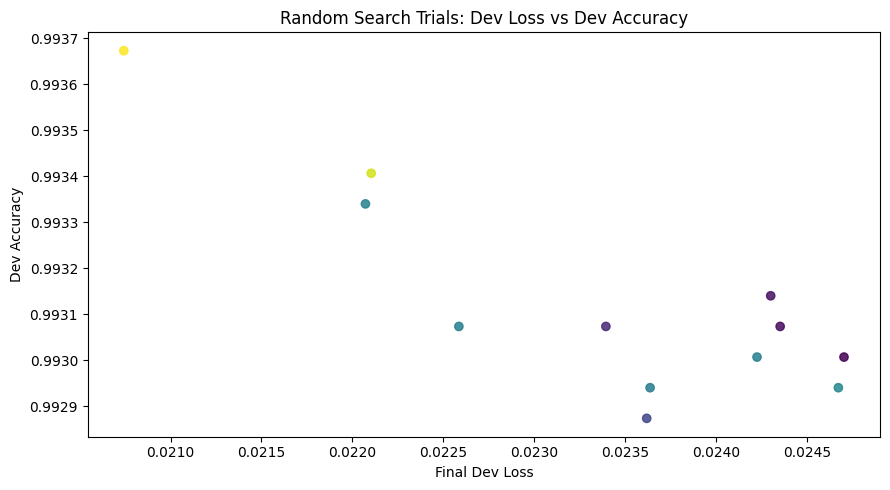

In [77]:
search_rng = np.random.default_rng(RANDOM_SEED + 100)


def sample_config(rng: np.random.Generator) -> Dict[str, object]:
    optimizer = str(rng.choice(['sgd', 'rmsprop', 'adam']))
    hidden_dim = int(rng.choice([16, 24, 32, 48, 64, 96]))

    if optimizer == 'sgd':
        lr = float(10 ** rng.uniform(-2.4, -1.0))
    elif optimizer == 'rmsprop':
        lr = float(10 ** rng.uniform(-3.5, -2.0))
    else:
        lr = float(10 ** rng.uniform(-3.6, -2.1))

    return {
        'optimizer': optimizer,
        'hidden_dim': hidden_dim,
        'learning_rate': lr,
        'weight_decay': float(10 ** rng.uniform(-6.0, -3.0)),
        'batch_size': int(rng.choice([64, 128, 256, 512])),
        'epochs': int(rng.choice([30, 45, 60])),
        'seed': int(rng.integers(1, 1_000_000)),
    }


N_RANDOM_TRIALS = 12
random_trials = []

for trial in range(1, N_RANDOM_TRIALS + 1):
    cfg = sample_config(search_rng)
    print(
        f"Trial {trial}/{N_RANDOM_TRIALS}: opt={cfg['optimizer']}, hidden={cfg['hidden_dim']}, "
        f"lr={cfg['learning_rate']:.5f}, wd={cfg['weight_decay']:.6f}, bs={cfg['batch_size']}, epochs={cfg['epochs']}"
    )

    _, result = run_torch_experiment(
        label=f"trial_{trial}",
        optimizer_name=str(cfg['optimizer']),
        X_train=X_train_part2_norm,
        y_train_np=y_train_part2_core,
        X_dev=X_dev_part2_norm,
        y_dev_np=y_dev_part2,
        X_test=X_test_part2_norm,
        y_test_np=y_test_part2,
        hidden_dim=int(cfg['hidden_dim']),
        learning_rate=float(cfg['learning_rate']),
        weight_decay=float(cfg['weight_decay']),
        batch_size=int(cfg['batch_size']),
        epochs=int(cfg['epochs']),
        print_every=0,
        seed=int(cfg['seed']),
    )

    row = {k: v for k, v in result.items() if k != 'history'}
    row['trial'] = trial
    random_trials.append(row)

random_search_df = pd.DataFrame(random_trials).sort_values(
    ['final_dev_loss', 'dev_accuracy'],
    ascending=[True, False],
).reset_index(drop=True)

display(random_search_df.head(10))

best_trial = random_search_df.iloc[0]
print('\nBest random-search configuration (by dev loss):')
print(best_trial[['optimizer', 'hidden_dim', 'learning_rate', 'weight_decay', 'batch_size', 'epochs']])
print('\nBest-trial test metrics:')
print(best_trial[['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'final_test_loss']])

plt.figure(figsize=(9, 5))
scatter = plt.scatter(
    random_search_df['final_dev_loss'],
    random_search_df['dev_accuracy'],
    c=random_search_df['runtime_sec'],
    cmap='viridis',
    alpha=0.85,
)
plt.xlabel('Final Dev Loss')
plt.ylabel('Dev Accuracy')
plt.title('Random Search Trials: Dev Loss vs Dev Accuracy')
plt.tight_layout()
plt.show()
